In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-20627efa-4e36-6c0a-302b-c1de80771f15)


In [ ]:
import pandas as pd
import tensorflow as tf 
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/subjects-questions.csv')

In [ ]:
df.head()

,eng,Subject
0,An anti-forest measure is\nA. Afforestation\nB...,Biology
1,"Among the following organic acids, the acid pr...",Chemistry
2,If the area of two similar triangles are equal...,Maths
3,"In recent year, there has been a growing\nconc...",Biology
4,Which of the following statement\nregarding tr...,Physics


In [ ]:
df.shape

(122519, 2)

In [ ]:
df.Subject.value_counts()

Physics      38438
Chemistry    37767
Maths        33190
Biology      13124
Name: Subject, dtype: int64

<Axes: >

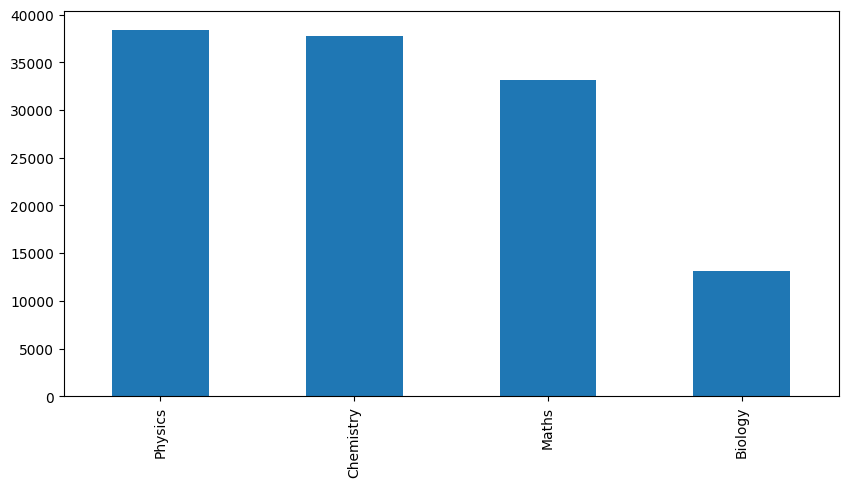

In [ ]:
plt.figure(figsize=(10,5))
df.Subject.value_counts().plot(kind='bar')

In [ ]:
import string

punctuation_chars = string.punctuation
    
#clean text data in specified column of the DataFrame
df['eng'] = df['eng'].apply(lambda x: ''.join(char for char in str(x) if char not in punctuation_chars))

In [ ]:
df

,eng,Subject
0,An antiforest measure is\nA Afforestation\nB S...,Biology
1,Among the following organic acids the acid pre...,Chemistry
2,If the area of two similar triangles are equal...,Maths
3,In recent year there has been a growing\nconce...,Biology
4,Which of the following statement\nregarding tr...,Physics
...,...,...
122514,Which of the following group of\ncharacters is...,Biology
122515,Light year is the\nA light emitted by the sun ...,Physics
122516,Member of Dipnoi are native of\nA India\nB Afr...,Biology
122517,In one averagelife\nA half the active nuclei d...,Physics


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stopwords(text):
    try:
        stopwords.words('english')
    except LookupError:
        import nltk
        nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text

In [ ]:
df['eng'] = df['eng'].apply(remove_stopwords)

In [ ]:
df.head()

,eng,Subject
0,antiforest measure Afforestation B Selective g...,Biology
1,Among following organic acids acid present ran...,Chemistry
2,area two similar triangles equal equilateral B...,Maths
3,recent year growing concern gradually increasi...,Biology
4,following statement regarding transformer inco...,Physics


In [ ]:
#df_encoded = pd.get_dummies(df, columns=['Subject'],prefix='',prefix_sep='')

In [ ]:
#df_encoded

In [ ]:
#df_encoded[['Biology',	'Chemistry',	'Maths',	'Physics']].to_numpy()

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform( df["Subject"].to_numpy())

In [ ]:
label_encoded

array([0, 1, 2, ..., 0, 3, 3])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder( sparse_output=False)
one_hot_encoded = one_hot_encoder.fit_transform( df["Subject"].to_numpy().reshape(-1, 1))

In [ ]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels_encoded, val_labels_encoded = train_test_split(df['eng'].to_numpy(),
                                                                            label_encoded,
                                                                            test_size=0.2, 
                                                                            random_state=42) 

In [ ]:
len(train_sentences), len(val_sentences)

(98015, 24504)

In [ ]:
train_sentences[20]

'BOD refers amount oxygen consumed organic matter 1000 mathrmml water oxidized bacteria B amount oxygen released organic matter consumed bacteria 1 litre water C oxygen required bacteria grow 1 litre effluent amount oxygen released organic matter 1000 mathrmml water oxidized bacteria'

In [ ]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

22

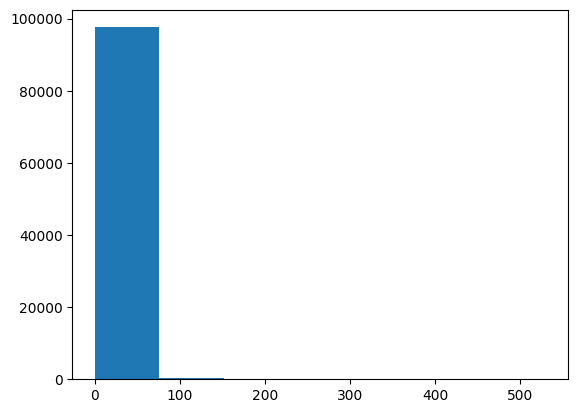

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
sent_lens = [len(sentence.split()) for sentence in train_sentences]

plt.hist(sent_lens, bins=7);

In [ ]:
output_seq_len = int( np.percentile( sent_lens, 95 ) )
output_seq_len

47

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

# fit tokenizer on text column of DataFrame
tokenizer.fit_on_texts(df['eng'])

# find maximum number of words in the vocabulary
max_vocab_size = len(tokenizer.word_index)

print("Maximum vocabulary size:", max_vocab_size)

Maximum vocabulary size: 118149


In [ ]:
#max_tokens = 40000

In [ ]:
text_vectorizer = TextVectorization(max_tokens = max_vocab_size, 
                                    standardize="lower_and_strip_punctuation",
                                    output_mode="int",
                                    output_sequence_length = output_seq_len) 

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text:{len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
Sugar element B mixture C compound none

Length of text:7

Vectorized text:
[[869 231   3 330   2 126  25   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]]


In [ ]:
text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(text_vocab)}"), 
print(f"Most common words in the vocabulary: {text_vocab[:5]}")
print(f"Least common words in the vocabulary: {text_vocab[-5:]}")

Number of words in vocabulary: 102605
Most common words in the vocabulary: ['', '[UNK]', 'c', 'b', 'cdot']
Least common words in the vocabulary: ['000029', '000025', '000014', '000002', '0000012']


In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = len(text_vocab), 
                             output_dim=128, 
                             embeddings_initializer="uniform", 
                             input_length= output_seq_len, 
                             mask_zero=True,
                             name="embedding_1") 
embedding

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_1 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])
model_1.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_1.score(X= val_sentences,y = val_labels_encoded)

0.9062193927522038

In [ ]:
#helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-10 12:24:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-10 12:24:38 (121 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
model_1_results = calculate_results(y_true=val_labels_encoded,y_pred= model_1.predict(val_sentences))

In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(df['eng'].to_numpy(),
                                                                            one_hot_encoded,
                                                                            test_size=0.2, 
                                                                            random_state=42) 

In [ ]:
train_sentences[20]

'BOD refers amount oxygen consumed organic matter 1000 mathrmml water oxidized bacteria B amount oxygen released organic matter consumed bacteria 1 litre water C oxygen required bacteria grow 1 litre effluent amount oxygen released organic matter 1000 mathrmml water oxidized bacteria'

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels))

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 4), dtype=tf.float64, name=None))>

In [ ]:
from helper_functions import create_tensorboard_callback
SAVE_DIR = "model_logs"

In [ ]:
earlystoping_callback = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True, 
                                                         monitor = 'val_accuracy')

In [ ]:
model_2 = tf.keras.Sequential([
    text_vectorizer,
    embedding,
    tf.keras.layers.Conv1D(64, 
                           kernel_size = 5,
                           padding = 'same',
                           activation = 'relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])


In [ ]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 47)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 47, 128)           13133440  
                                                                 
 conv1d (Conv1D)             (None, 47, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8

In [ ]:
model_2_history = model_2.fit(train_dataset,
                              #steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=20,
                              validation_data=valid_dataset,
                              #validation_steps=int(0.1*len(valid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "Conv1D"), earlystoping_callback]) 

Saving TensorBoard log files to: model_logs/Conv1D/20230406-210442
Epoch 1/20
3063/3063 [==============================] - 77s 24ms/step - loss: 0.3064 - accuracy: 0.8920 - val_loss: 0.1985 - val_accuracy: 0.9314
Epoch 2/20
3063/3063 [==============================] - 26s 9ms/step - loss: 0.1358 - accuracy: 0.9536 - val_loss: 0.2138 - val_accuracy: 0.9329
Epoch 3/20
3063/3063 [==============================] - 26s 8ms/step - loss: 0.0945 - accuracy: 0.9671 - val_loss: 0.2307 - val_accuracy: 0.9325
Epoch 4/20
3063/3063 [==============================] - 26s 8ms/step - loss: 0.0705 - accuracy: 0.9752 - val_loss: 0.2455 - val_accuracy: 0.9306
Epoch 5/20
3063/3063 [==============================] - 26s 8ms/step - loss: 0.0523 - accuracy: 0.9815 - val_loss: 0.2877 - val_accuracy: 0.9273
Epoch 6/20
3063/3063 [==============================] - 26s 8ms/step - loss: 0.0411 - accuracy: 0.9858 - val_loss: 0.3264 - val_accuracy: 0.9282
Epoch 7/20
3063/3063 [==============================] - 26s 8m

In [ ]:
model_2.evaluate(valid_dataset)

766/766 [==============================] - 2s 3ms/step - loss: 0.2138 - accuracy: 0.9329


[0.21381334960460663, 0.9329497218132019]

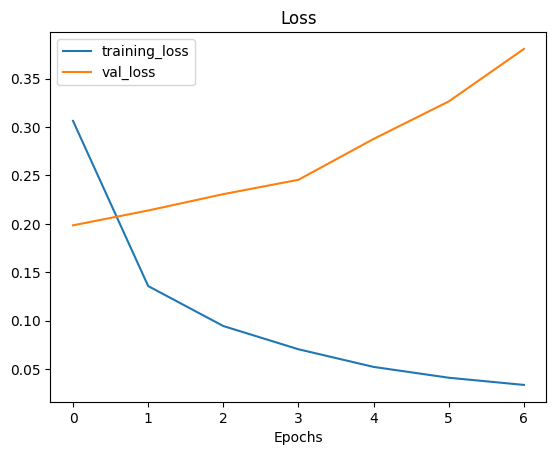

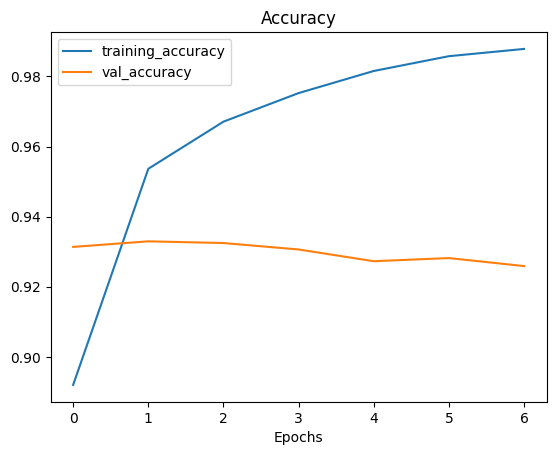

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(model_2_history)

In [ ]:
model_2.predict(valid_dataset)

766/766 [==============================] - 2s 2ms/step


array([[7.1362773e-09, 1.1262082e-06, 1.5088956e-01, 8.4910929e-01],
       [3.3152741e-03, 9.8209548e-01, 9.4110164e-04, 1.3648121e-02],
       [2.1564579e-04, 9.9438077e-01, 2.2733094e-04, 5.1762569e-03],
       ...,
       [1.0285396e-02, 7.8118402e-01, 7.8544049e-03, 2.0067616e-01],
       [5.4996862e-12, 8.3207922e-08, 6.0377453e-05, 9.9993944e-01],
       [1.1901152e-03, 9.7707206e-01, 4.3912692e-04, 2.1298718e-02]],
      dtype=float32)

In [ ]:
model_2_pred=tf.argmax(model_2.predict(valid_dataset),axis=1)

766/766 [==============================] - 2s 3ms/step


In [ ]:
model_2_pred

<tf.Tensor: shape=(24504,), dtype=int64, numpy=array([3, 1, 1, ..., 1, 3, 1])>

In [ ]:
val_labels

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [ ]:
model_2_results = calculate_results(val_labels_encoded, model_2_pred)
model_2_results

{'accuracy': 93.29497224942867,
 'precision': 0.9330455865283164,
 'recall': 0.9329497224942866,
 'f1': 0.932732025157064}

In [ ]:
model_3 = tf.keras.Sequential([
    text_vectorizer,
    embedding,
    tf.keras.layers.LSTM(64),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation= 'relu'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

model_3.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
                metrics = ['accuracy'])


In [ ]:
model_3_history = model_3.fit(train_dataset,
                              #steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=20,
                              validation_data=valid_dataset,
                              #validation_steps=int(0.1*len(valid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "LSTM"), earlystoping_callback]) 

Saving TensorBoard log files to: model_logs/LSTM/20230406-210922
Epoch 1/20
3063/3063 [==============================] - 83s 25ms/step - loss: 0.2510 - accuracy: 0.9386 - val_loss: 0.2485 - val_accuracy: 0.9348
Epoch 2/20
3063/3063 [==============================] - 43s 14ms/step - loss: 0.0978 - accuracy: 0.9722 - val_loss: 0.2401 - val_accuracy: 0.9364
Epoch 3/20
3063/3063 [==============================] - 44s 14ms/step - loss: 0.0825 - accuracy: 0.9761 - val_loss: 0.2430 - val_accuracy: 0.9362
Epoch 4/20
3063/3063 [==============================] - 44s 14ms/step - loss: 0.0702 - accuracy: 0.9793 - val_loss: 0.2566 - val_accuracy: 0.9364
Epoch 5/20
3063/3063 [==============================] - 43s 14ms/step - loss: 0.0627 - accuracy: 0.9812 - val_loss: 0.2658 - val_accuracy: 0.9361
Epoch 6/20
3063/3063 [==============================] - 43s 14ms/step - loss: 0.0560 - accuracy: 0.9828 - val_loss: 0.2782 - val_accuracy: 0.9349
Epoch 7/20
3063/3063 [==============================] - 43s

In [ ]:
model_3.evaluate(valid_dataset)

766/766 [==============================] - 5s 6ms/step - loss: 0.2401 - accuracy: 0.9364


[0.24014590680599213, 0.9364185333251953]

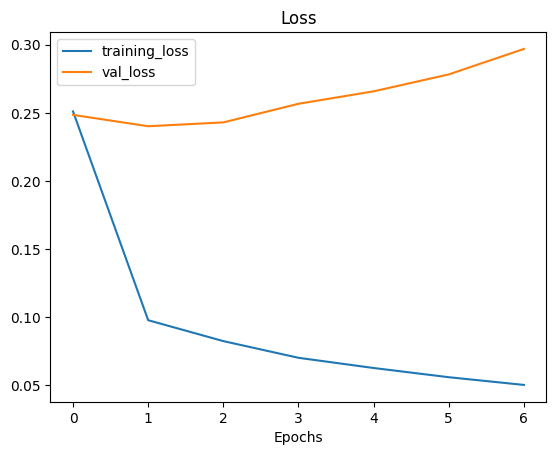

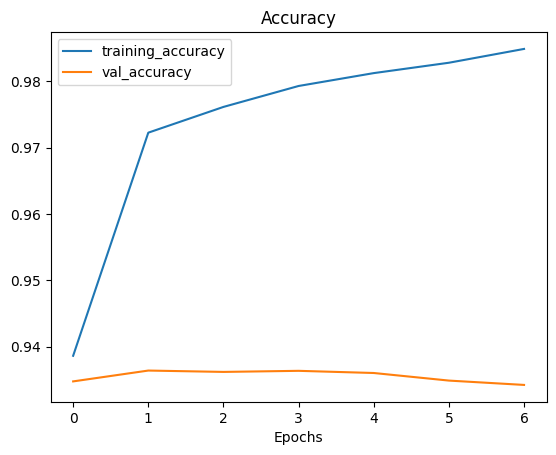

In [ ]:
plot_loss_curves(model_3_history)

In [ ]:
model_3_pred=tf.argmax(model_3.predict(valid_dataset),axis=1)

766/766 [==============================] - 4s 3ms/step


In [ ]:
model_3_results = calculate_results(val_labels_encoded, model_3_pred)
model_3_results

{'accuracy': 93.64185439111982,
 'precision': 0.9364782875374693,
 'recall': 0.9364185439111982,
 'f1': 0.9364181594365598}

In [ ]:
model_4 = tf.keras.Sequential([
    text_vectorizer,
    embedding,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(256, activation= 'relu'),
    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

model_4.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# earlystoping_callback = tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True, 
#                                                          monitor = 'val_accuracy')

In [ ]:
model_4_history = model_4.fit(train_dataset,
                              #steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=20,
                              validation_data=valid_dataset,
                              #validation_steps=int(0.1*len(valid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "Bidirectional_LSTM"), earlystoping_callback]) 

Saving TensorBoard log files to: model_logs/Bidirectional_LSTM/20230406-211630
Epoch 1/20
3063/3063 [==============================] - 105s 31ms/step - loss: 0.1084 - accuracy: 0.9645 - val_loss: 0.2289 - val_accuracy: 0.9320
Epoch 2/20
3063/3063 [==============================] - 62s 20ms/step - loss: 0.0621 - accuracy: 0.9784 - val_loss: 0.3347 - val_accuracy: 0.9212
Epoch 3/20
3063/3063 [==============================] - 61s 20ms/step - loss: 0.0380 - accuracy: 0.9866 - val_loss: 0.3658 - val_accuracy: 0.9233
Epoch 4/20
3063/3063 [==============================] - 62s 20ms/step - loss: 0.0263 - accuracy: 0.9905 - val_loss: 0.4362 - val_accuracy: 0.9258
Epoch 5/20
3063/3063 [==============================] - 60s 20ms/step - loss: 0.0185 - accuracy: 0.9933 - val_loss: 0.4544 - val_accuracy: 0.9261
Epoch 6/20
3063/3063 [==============================] - 62s 20ms/step - loss: 0.0163 - accuracy: 0.9940 - val_loss: 0.5056 - val_accuracy: 0.9271


In [ ]:
model_4.evaluate(valid_dataset)

766/766 [==============================] - 5s 6ms/step - loss: 0.2289 - accuracy: 0.9320


[0.22892330586910248, 0.9319702982902527]

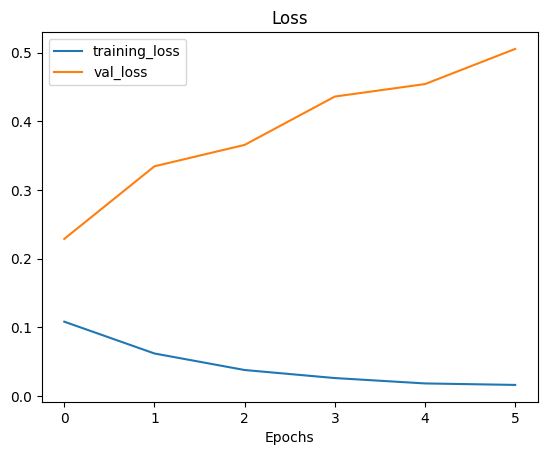

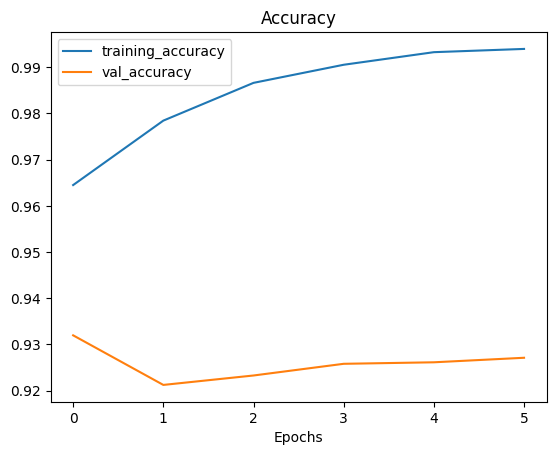

In [ ]:
plot_loss_curves(model_4_history)

In [ ]:
model_4_pred=tf.argmax(model_4.predict(valid_dataset),axis=1)

766/766 [==============================] - 7s 5ms/step


In [ ]:
model_4_results = calculate_results(val_labels_encoded, model_4_pred)
model_4_results

{'accuracy': 93.19702905648057,
 'precision': 0.9320894947421229,
 'recall': 0.9319702905648057,
 'f1': 0.9319478260746885}

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
sentence_encoder = hub.KerasLayer(embed,
                                  input_shape=[],
                                  dtype = tf.string,
                                  trainable = False)

In [ ]:
model_5 = tf.keras.Sequential([
    hub.KerasLayer(hub.load("https://tfhub.dev/google/universal-sentence-encoder/4"),
                   input_shape=[],
                   dtype = tf.string,
                   trainable = False),
    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.Dense(4, activation = 'softmax')

])

model_5.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# earlystoping_callback = tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True, 
#                                                          monitor = 'val_accuracy')

In [ ]:
model_5_history = model_5.fit(train_dataset,
                              #steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=20,
                              validation_data=valid_dataset,
                              #validation_steps=int(0.1*len(valid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "USE"), earlystoping_callback]) 


Got `type(handle)`: <class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'>


Saving TensorBoard log files to: model_logs/USE/20230406-212510
Epoch 1/20
3063/3063 [==============================] - 57s 17ms/step - loss: 0.3045 - accuracy: 0.8879 - val_loss: 0.2668 - val_accuracy: 0.9032
Epoch 2/20
3063/3063 [==============================] - 49s 16ms/step - loss: 0.2373 - accuracy: 0.9125 - val_loss: 0.2448 - val_accuracy: 0.9109
Epoch 3/20
3063/3063 [==============================] - 49s 16ms/step - loss: 0.2060 - accuracy: 0.9247 - val_loss: 0.2389 - val_accuracy: 0.9145
Epoch 4/20
3063/3063 [==============================] - 48s 16ms/step - loss: 0.1819 - accuracy: 0.9345 - val_loss: 0.2396 - val_accuracy: 0.9155
Epoch 5/20
3063/3063 [==============================] - 46s 15ms/step - loss: 0.1611 - accuracy: 0.9416 - val_loss: 0.2483 - val_accuracy: 0.9150
Epoch 6/20
3063/3063 [==============================] - 48s 16ms/step - loss: 0.1427 - accuracy: 0.9489 - val_loss: 0.2612 - val_accuracy: 0.9138
Epoch 7/20
3063/3063 [==============================] - 46s 

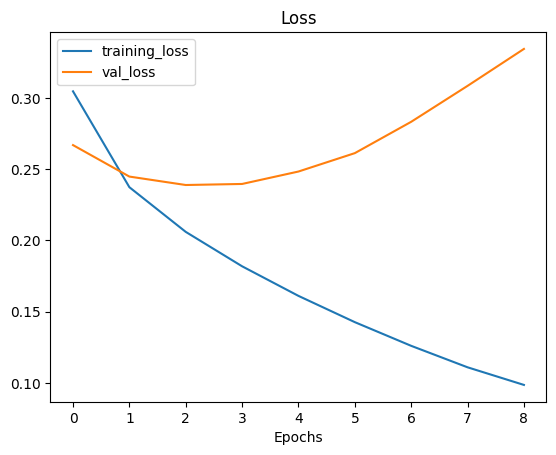

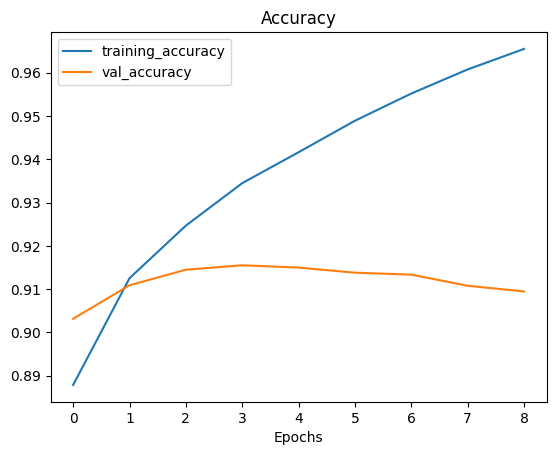

In [ ]:
plot_loss_curves(model_5_history)

In [ ]:
model_5_pred=tf.argmax(model_5.predict(valid_dataset),axis=1)

766/766 [==============================] - 8s 10ms/step


In [ ]:
model_5_results = calculate_results(val_labels_encoded, model_5_pred)
model_5_results

{'accuracy': 91.55239960822723,
 'precision': 0.915277189814202,
 'recall': 0.9155239960822723,
 'f1': 0.9152985182255496}

In [ ]:
all_model_results = pd.DataFrame({ "Baseline": model_1_results,
                                   "Conv1d": model_2_results,
                                   "LSTM": model_3_results,
                                   "Bidirectional_Lstm": model_4_results,
                                   "pretrained_embed": model_5_results })

all_model_results = all_model_results.transpose()

all_model_results

,accuracy,precision,recall,f1
Baseline,90.621939,0.910119,0.906219,0.905769
Conv1d,93.294972,0.933046,0.932950,0.932732
LSTM,93.641854,0.936478,0.936419,0.936418
Bidirectional_Lstm,93.197029,0.932089,0.931970,0.931948
pretrained_embed,91.552400,0.915277,0.915524,0.915299


### Transfer Learning

### Choose bert model

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
#!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 46.5 MB/s eta 0:00:00


### Define your model

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1', trainable=False, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  #net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(4, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
model_6 = build_classifier_model()

model_6.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_6.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [ ]:
model_6_history = model_6.fit(train_dataset,
                              #steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=20,
                              validation_data=valid_dataset,
                              #validation_steps=int(0.1*len(valid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bert"), earlystoping_callback]) 

Saving TensorBoard log files to: model_logs/bert/20230410-133917
Epoch 1/20
3063/3063 [==============================] - 462s 149ms/step - loss: 0.5617 - accuracy: 0.7913 - val_loss: 0.4844 - val_accuracy: 0.8228
Epoch 2/20
3063/3063 [==============================] - 439s 143ms/step - loss: 0.4691 - accuracy: 0.8278 - val_loss: 0.4603 - val_accuracy: 0.8312
Epoch 3/20
3063/3063 [==============================] - 436s 142ms/step - loss: 0.4517 - accuracy: 0.8345 - val_loss: 0.4491 - val_accuracy: 0.8348
Epoch 4/20
3063/3063 [==============================] - 436s 142ms/step - loss: 0.4423 - accuracy: 0.8373 - val_loss: 0.4421 - val_accuracy: 0.8388
Epoch 5/20
3063/3063 [==============================] - 434s 142ms/step - loss: 0.4360 - accuracy: 0.8398 - val_loss: 0.4372 - val_accuracy: 0.8403
Epoch 6/20
3063/3063 [==============================] - 435s 142ms/step - loss: 0.4315 - accuracy: 0.8418 - val_loss: 0.4335 - val_accuracy: 0.8416
Epoch 7/20
3063/3063 [=========================